# Curse of dimensionality and effect of sample size

*Pelin Yurdadön*

Ekim 2021

**Libraries & Functions**

In [1]:
options(warn = -1)
library(data.table) # for easy data handling
library(ggplot2) # for graphs
library(stringr) # 
library(tidyverse) # provides a nice combination of nice packages

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.1.0     v purrr   0.3.4
v tidyr   1.1.3     v dplyr   1.0.5
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x purrr::flatten()   masks jsonlite::flatten()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::transpose() masks data.table::transpose()



In [2]:
# creates a datatable with random numbers 
create_dimensions = function(D,N = 1000,selected_seed){
    set.seed(selected_seed)
    D_frame = data.table()
    for(d in c(1:D)){ 
        D_frame = cbind(D_frame, runif(N, min = -1, max = 1))
    }
    setnames(D_frame, paste0("dim_",c(1:d)))
    return(D_frame)
}

In [11]:
# obtains distance to the origin for each observation
obtain_distance_to_origin = function(D_frame){
    dist_frame = copy(D_frame)
    dim_cols =colnames(D_frame)[str_detect(colnames(D_frame),"dim")]
    dist_frame[,(dim_cols):= .SD^2,.SDcols = dim_cols]
    dist_frame[,dist := apply(.SD,1,sum),.SDcols = dim_cols]
    dist_frame[,dist := sqrt(dist)]
    return(dist_frame)
}

In [5]:
# calculates euclidian distance between two instances
calculate_euc_distance = function(x,y){
    return( sqrt(sum((x - y)^2)))
}

In [4]:
# calculates the distance to the nearest neighbor of a point
distance_to_nn = function(original_frame, D_frame){    
    dist_nn_frame = data.table()
    for(i in c(1:nrow(original_frame))){
        focus_point = original_frame[i]
        min_distance = 1000
        for(j in c(1:nrow(D_frame))){
            other_point = D_frame[j]
            dist_pointwise= calculate_euc_distance(other_point,focus_point)
            if(dist_pointwise < min_distance){ 
                min_distance = copy(dist_pointwise)
                min_distance_ins = j
            }
        }
        dist_nn_frame = rbind(dist_nn_frame
                             ,data.table(D,test_ins = i, training_ins = min_distance_ins,min_distance))
        
    }
    return(dist_nn_frame)
}

In [6]:
# calulates the fration of points close by the origin
calculate_fraction = function(dist_frame,dist_threshold = 1){
    return(nrow(dist_frame[dist <= dist_threshold])/( nrow(dist_frame)))
}

**Parameters**

In [7]:
N = 1000 # number of points in each dimension
D_list = c(1:15) # list of dimensions D

## Dimension vs Coverage

In [8]:
frac_list = c()
for(D in D_list){
    D_frame = create_dimensions(D,N,selected_seed = 0)
    dist_frame = obtain_distance_to_origin(D_frame)
    frac_list = c(frac_list,calculate_fraction(dist_frame))
}

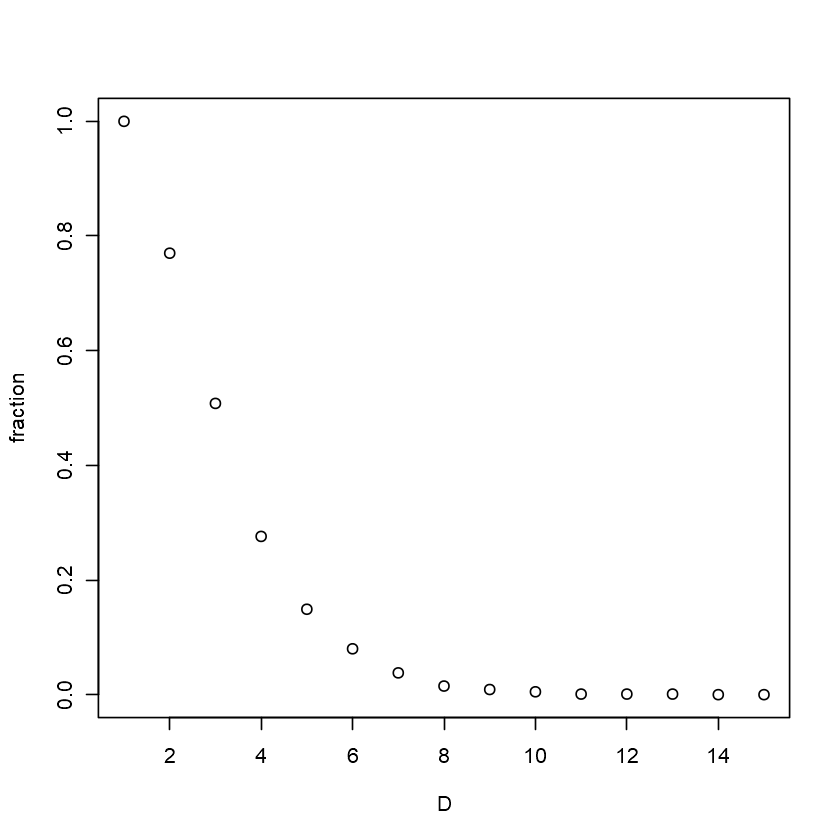

In [9]:
plot(frac_list,
    xlab = "D",
    ylab = "fraction") 


## Estimating pi

**in 2D, points are separated like below**

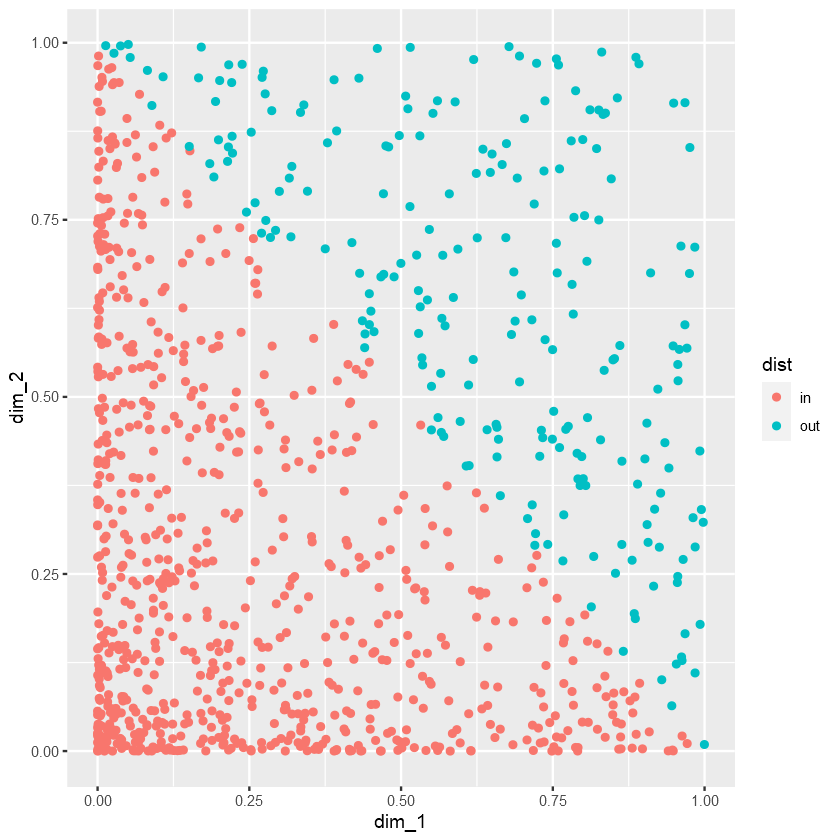

In [30]:
D_frame = create_dimensions(2,1000,selected_seed = 0) 
dist_frame = obtain_distance_to_origin(D_frame)
dist_frame[,dist := ifelse(dist <1, "in","out")]

ggplot(data = dist_frame, aes(x= dim_1, y = dim_2, color = dist)) + geom_point() 

Since points cover only the 1/4 of a unit square, we need to multiply the fraction (we found previously for 2D) by 4.

In [31]:
pi_estimate_2D = frac_list[2]*4
pi_estimate_2D

[1] 3.08

**for 3D**

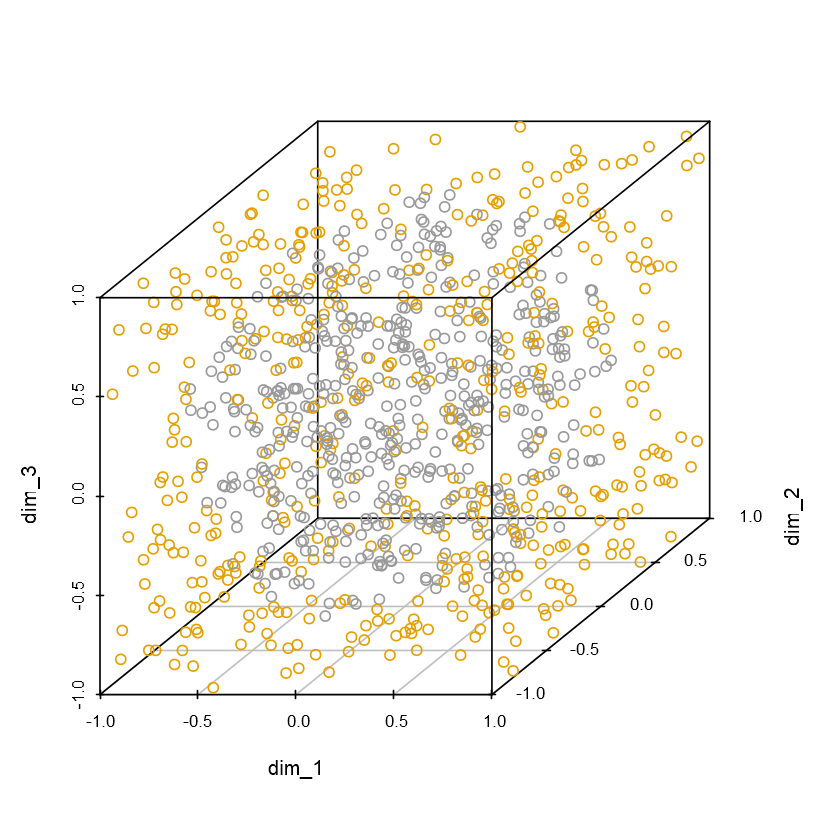

In [42]:
D_frame = create_dimensions(3,1000,selected_seed = 0) 
dist_frame = obtain_distance_to_origin(D_frame)
dist_frame[,dist := ifelse(dist <1, "in","out")]

colors <- ifelse(dist_frame$dist == "in","#999999","#E69F00")
library("scatterplot3d") # load
scatterplot3d(D_frame[,1:3], color = colors)

Remember the volume formula is (4/3)*pi*r^3. When r =1, V = (4/3)*pi.
On the other hand, volume of square = 8

Therefore our ratio will be ((4/3)*pi) / 8.
In other words, we must multiply our fraction by 6 to get pi.

In [43]:
pi_estimate_3D = frac_list[3]*6
pi_estimate_3D

[1] 3.048

**Note that** the estimation power decreases as dimension is increased from 2 to 3. 

Still, to be sure, lets simulate with different seeds. 
That is, lets reduce the variability in etimations due to the stochasticity embedded in the data generation. 

In [44]:
frac_frame_sim = c()
for(D in c(2:3)){
    for(k in c(1:100)){
        D_frame = create_dimensions(D,N = 1000,selected_seed = k*17-3)
        dist_frame = obtain_distance_to_origin(D_frame)
        frac = calculate_fraction(dist_frame)
        frac_frame_sim = rbind(frac_frame_sim,data.table(D = D, k = k, frac = frac), use.names = FALSE)
    }
}

In [46]:
frac_frame_sim[,.(pi_estimate = mean(frac)*(ifelse(D == 2,4,6))),.(D)] 

D pi_estimate
1 2 3.14408    
2 3 3.13380

**Simulation provided better results, yet, 3D estimation is slightly worse than 2D estimation**

## Simulations for pi

In [47]:
simulation_set = c(5000, 10000, 25000, 50000, 100000)

In [54]:
frac_frame = data.table()
for(D in c(2,3)){
    for(N in simulation_set){
        D_frame = create_dimensions(D,N,selected_seed = 10)
        dist_frame = obtain_distance_frame(D_frame)
        frac = calculate_fraction(dist_frame)
        frac_frame = rbind(frac_frame,data.table(D = D, N=N, frac = frac), use.names = FALSE)
    }
}


In [55]:
frac_frame[,pi := frac*(ifelse(D == 2,4,6))]
frac_frame

D N      frac    pi     
1  2   5000 0.78300 3.13200
2  2  10000 0.78580 3.14320
3  2  25000 0.78620 3.14480
4  2  50000 0.78498 3.13992
5  2 100000 0.78563 3.14252
6  3   5000 0.51820 3.10920
7  3  10000 0.52270 3.13620
8  3  25000 0.52344 3.14064
9  3  50000 0.52416 3.14496
10 3 100000 0.52364 3.14184

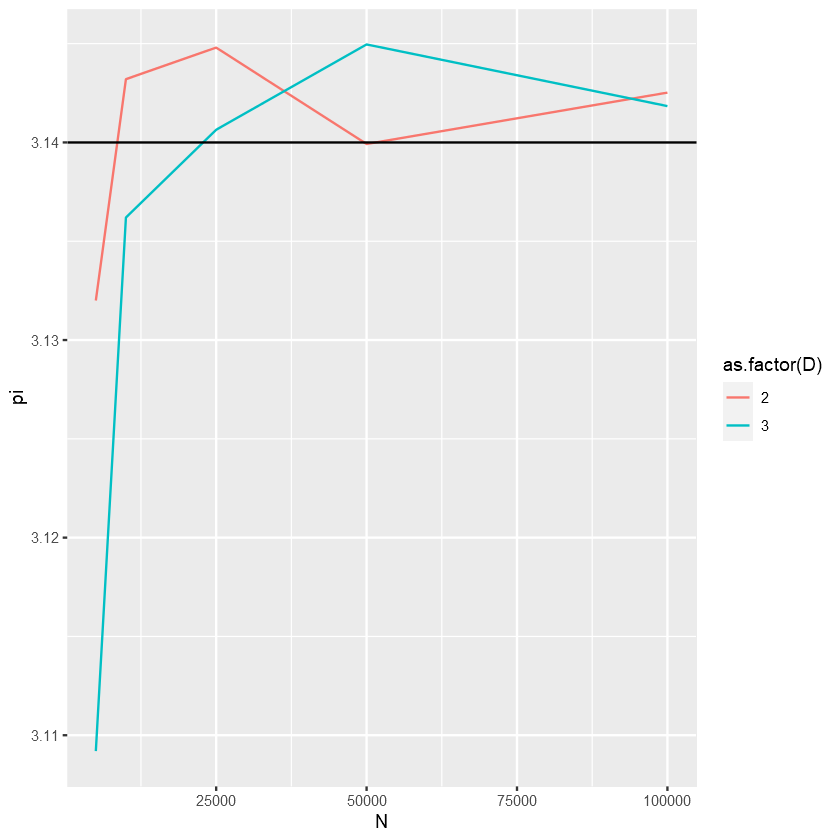

In [56]:
ggplot(data = frac_frame, aes(x = N, y = pi, group = as.factor(D), color = as.factor(D))) + geom_line() + geom_hline(yintercept = 3.14)

3D requires more data points to estimate pi at least as good as 2D. However, the randomness in the data generation process seems to affect the accuracy of the estimation for both. 
For instance, when the size of the data set is 50000, 3D estimation of pi appears to be better than 2D estimation. 

When a new data is generated with **another seed**, the effect of the data set on the estimation power is more obvious. While 2D pi estimation performs better with the data set obtained with seed 10 (N=5000), 3D pi estimation outperforms 2D estimation when seed is set to 0.


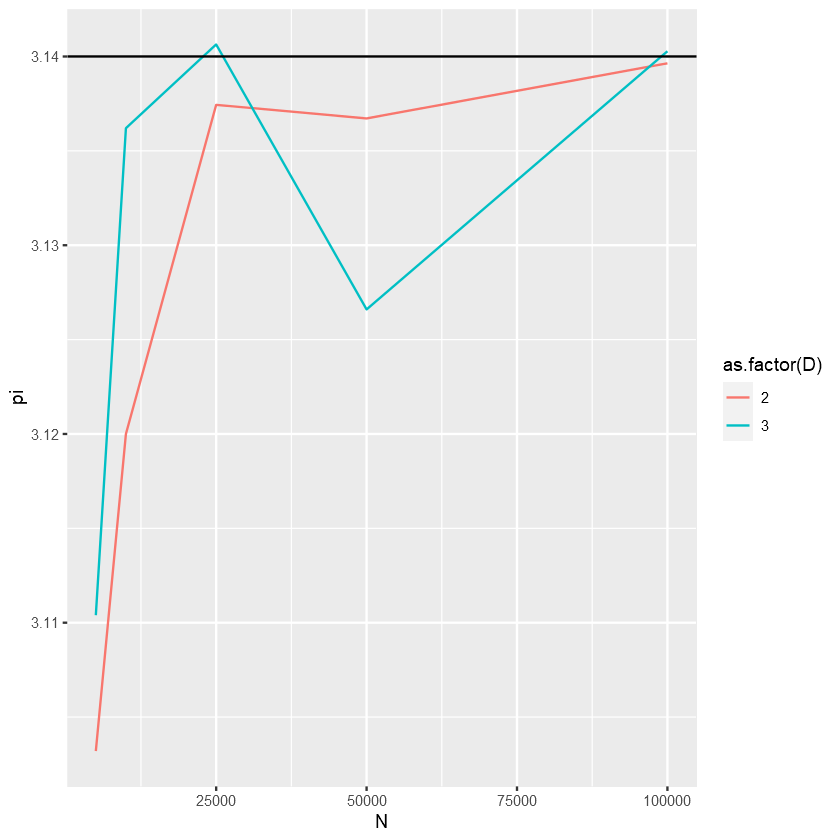

In [61]:
frac_frame = data.table()
for(D in c(2,3)){
    for(N in simulation_set){
        D_frame = create_dimensions(D,N,selected_seed = 0)
        dist_frame = obtain_distance_frame(D_frame)
        frac = calculate_fraction(dist_frame)
        frac_frame = rbind(frac_frame,data.table(D = D, N=N, frac = frac), use.names = FALSE)
    }
}
frac_frame[,pi := frac*(ifelse(D == 2,4,6))]
ggplot(data = frac_frame, aes(x = N, y = pi, group = as.factor(D), color = as.factor(D))) + geom_line() + geom_hline(yintercept = 3.14)

## Nearest Neighborhood Simulation

In [57]:
N = 1000
M = 100

In [58]:
dist_frame_all = data.table()
for(D in D_list){
    for(k in 1){ # sampling runs
        D_frame = create_dimensions(D,N,selected_seed = k*17-3)
        original_frame = create_dimensions(D,M,selected_seed = k*15-3)
        dist_frame = distance_to_nn(original_frame,D_frame)    
    }
  dist_frame_all = rbind(dist_frame_all,dist_frame)
}

fwrite(dist_frame_all,"dist_frame_all.csv")

In [59]:
head(dist_frame_all)

D test_ins training_ins min_distance
1 1 1        782          0.0016806410
2 1 2        259          0.0002616588
3 1 3        814          0.0002359771
4 1 4        189          0.0005110637
5 1 5        456          0.0003421581
6 1 6        332          0.0005817921

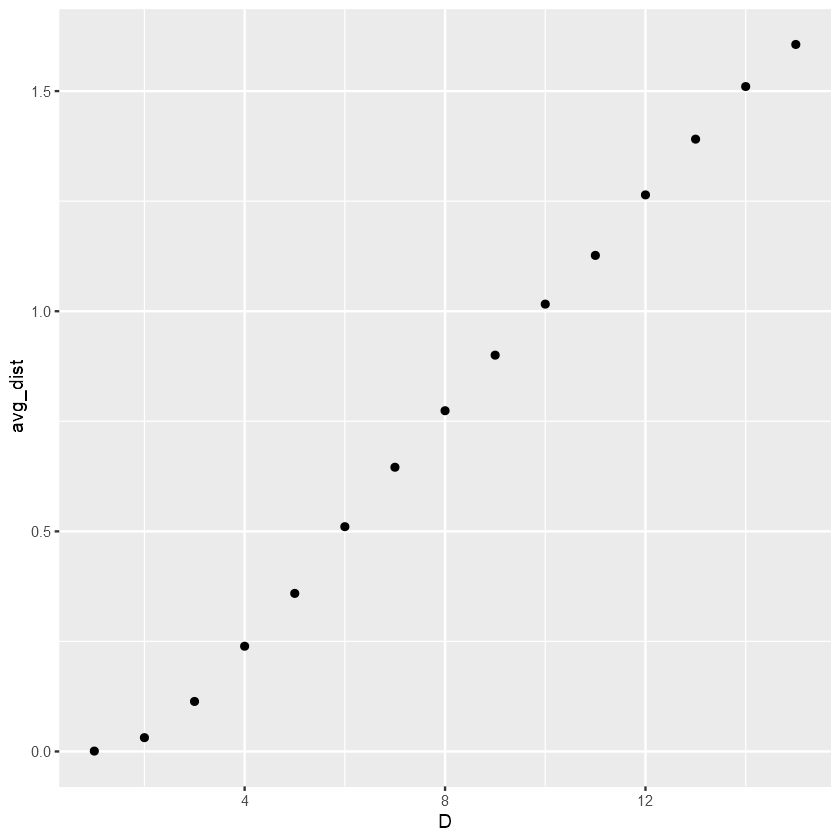

In [60]:
avg_distances = dist_frame_all[,.(avg_dist = mean(min_distance)),.(D)]
ggplot(data =avg_distances, aes(x = D, y =avg_dist ) ) + geom_point()

# Data Manipulation on Images

In [63]:
#install.packages("jpeg")
#install.packages("imager")
library(jpeg) # to display the images 
library(imager) # for easy image manipulations

imager library works with cimg type data sets. Cimg consists of 4 dimensions, 2 for the pixes, 1 for the channel, and the last one for another dimension like time. Since I feel more comfortable with cimg type, I used both jpeg and imager libraries.

## Image data structure 

In [64]:
pelin_jpeg = readJPEG("C:/Users/paslanpatir/fall21-yurdadonpelin/pelin_ie582.jpg",native = FALSE)
pelin_imager = load.image("C:/Users/paslanpatir/fall21-yurdadonpelin/pelin_ie582.jpg")

In [65]:
str(pelin_jpeg) # keeps data in numeric format
str(pelin_imager) # keeps data in cimg format

dim(pelin_imager)

 num [1:512, 1:512, 1:3] 0.29 0.439 0.357 0.247 0.302 ...
 'cimg' num [1:512, 1:512, 1, 1:3] 0.29 0.333 0.329 0.325 0.278 ...


[1] 512 512   1   3

pelin photo is represented in three dimensions with "jpeg" library. The first two dimensions corresponds to pixels, while the last one addresses the RGB channels. Only difference between jpeg library and imager library is that imager library incorporates one more dimension, which represents more detailed description of an image.

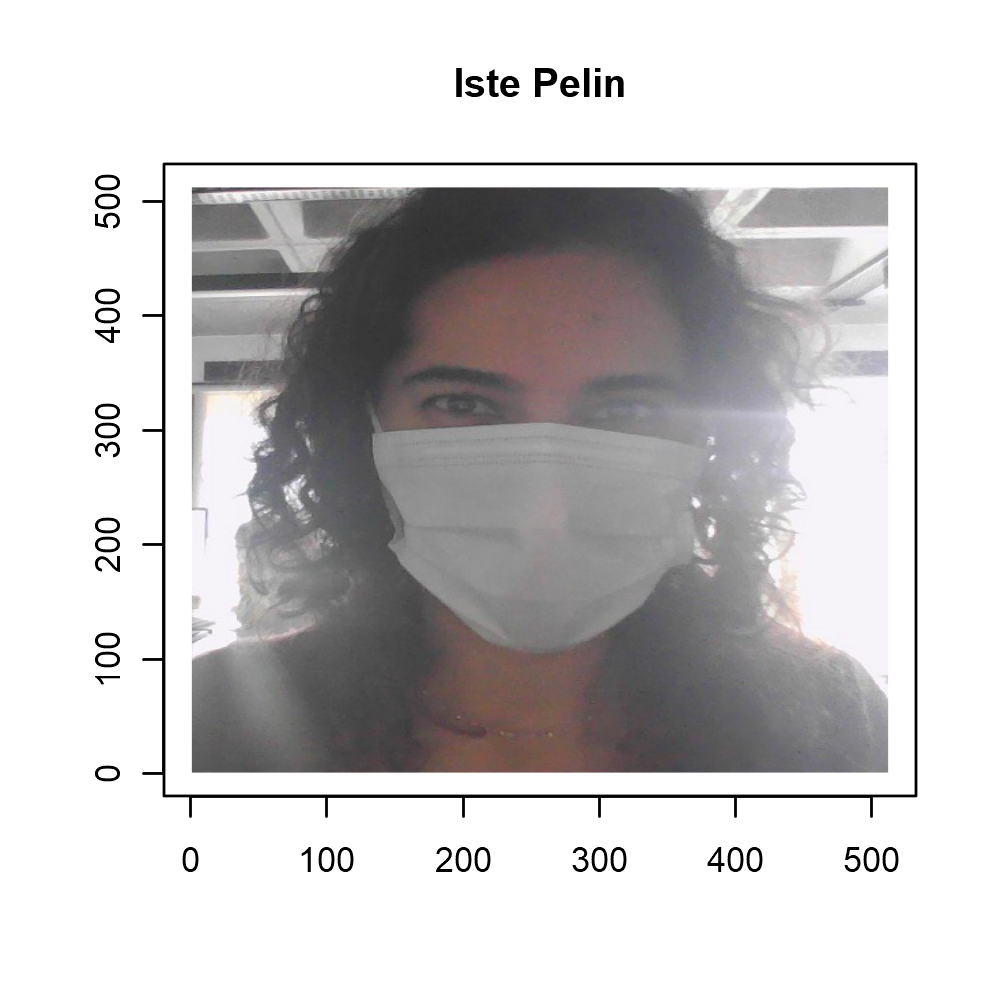

In [66]:
#display image
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "",main = "İşte Pelin")
rasterImage(pelin_jpeg, 1, 1, 512, 512, angle = 0, interpolate = TRUE)
## 512x512

## Displaying channels of an image

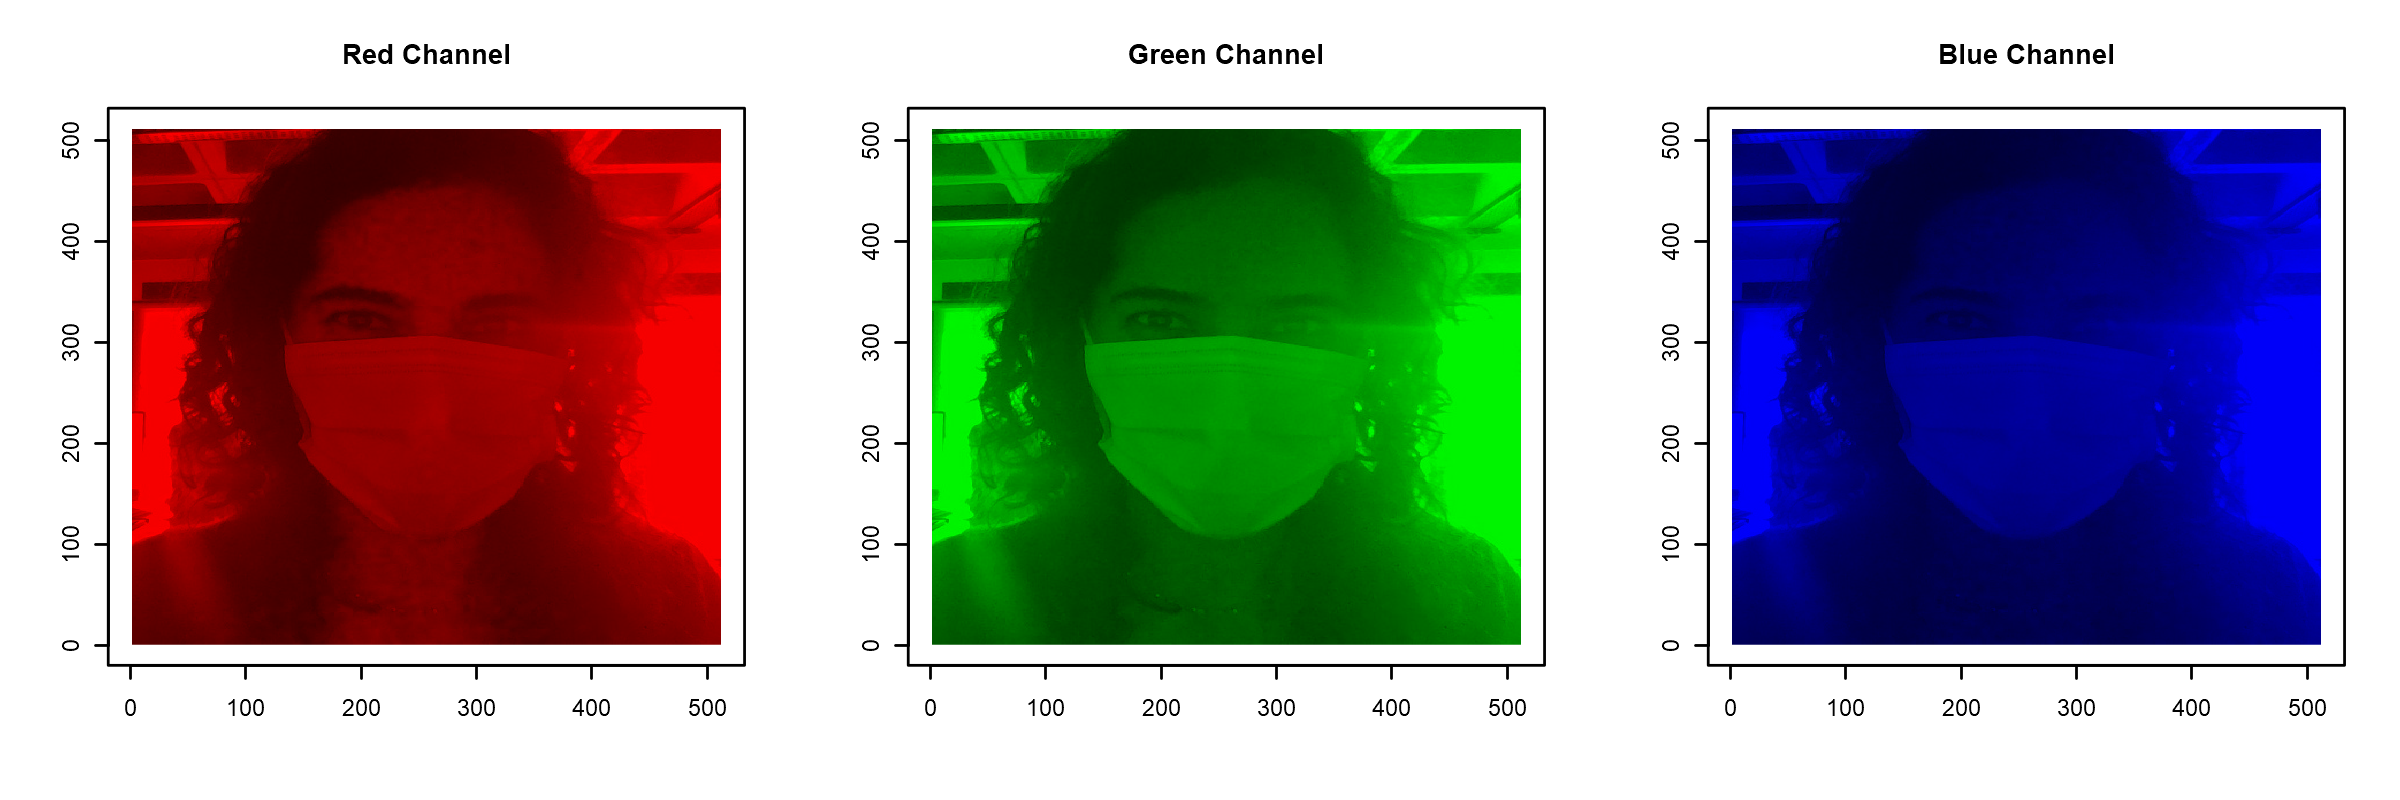

In [67]:
pelin_imager_red <- copy(pelin_imager)
G(pelin_imager_red) <- 0
B(pelin_imager_red) <- 0

pelin_imager_green <- copy(pelin_imager)
R(pelin_imager_green) <- 0
B(pelin_imager_green) <- 0

pelin_imager_blue <- copy(pelin_imager)
R(pelin_imager_blue) <- 0
G(pelin_imager_blue) <- 0

options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200)
# display each channel
par(mfrow = c(1, 3))
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "Red Channel")
rasterImage(pelin_imager_red, 1, 1, 512, 512, angle = 0, interpolate = FALSE)
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "Green Channel")
rasterImage(pelin_imager_green, 1, 1, 512, 512, angle = 0, interpolate = FALSE)
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "Blue Channel")
rasterImage(pelin_imager_blue, 1, 1, 512, 512, angle = 0, interpolate = FALSE)

## Averages on channels

In [68]:
image_dt = as.data.table(pelin_jpeg)
setnames(image_dt, c("x","y","channel","value"))
tail(image_dt,10)

x   y   channel value    
1  512 509 3       0.5411765
2  512 510 1       0.5215686
3  512 510 2       0.5176471
4  512 510 3       0.5372549
5  512 511 1       0.5254902
6  512 511 2       0.5215686
7  512 511 3       0.5411765
8  512 512 1       0.5372549
9  512 512 2       0.5333333
10 512 512 3       0.5529412

channel avg_value
1 1       0.5364349
2 2       0.5188845
3 3       0.5236176

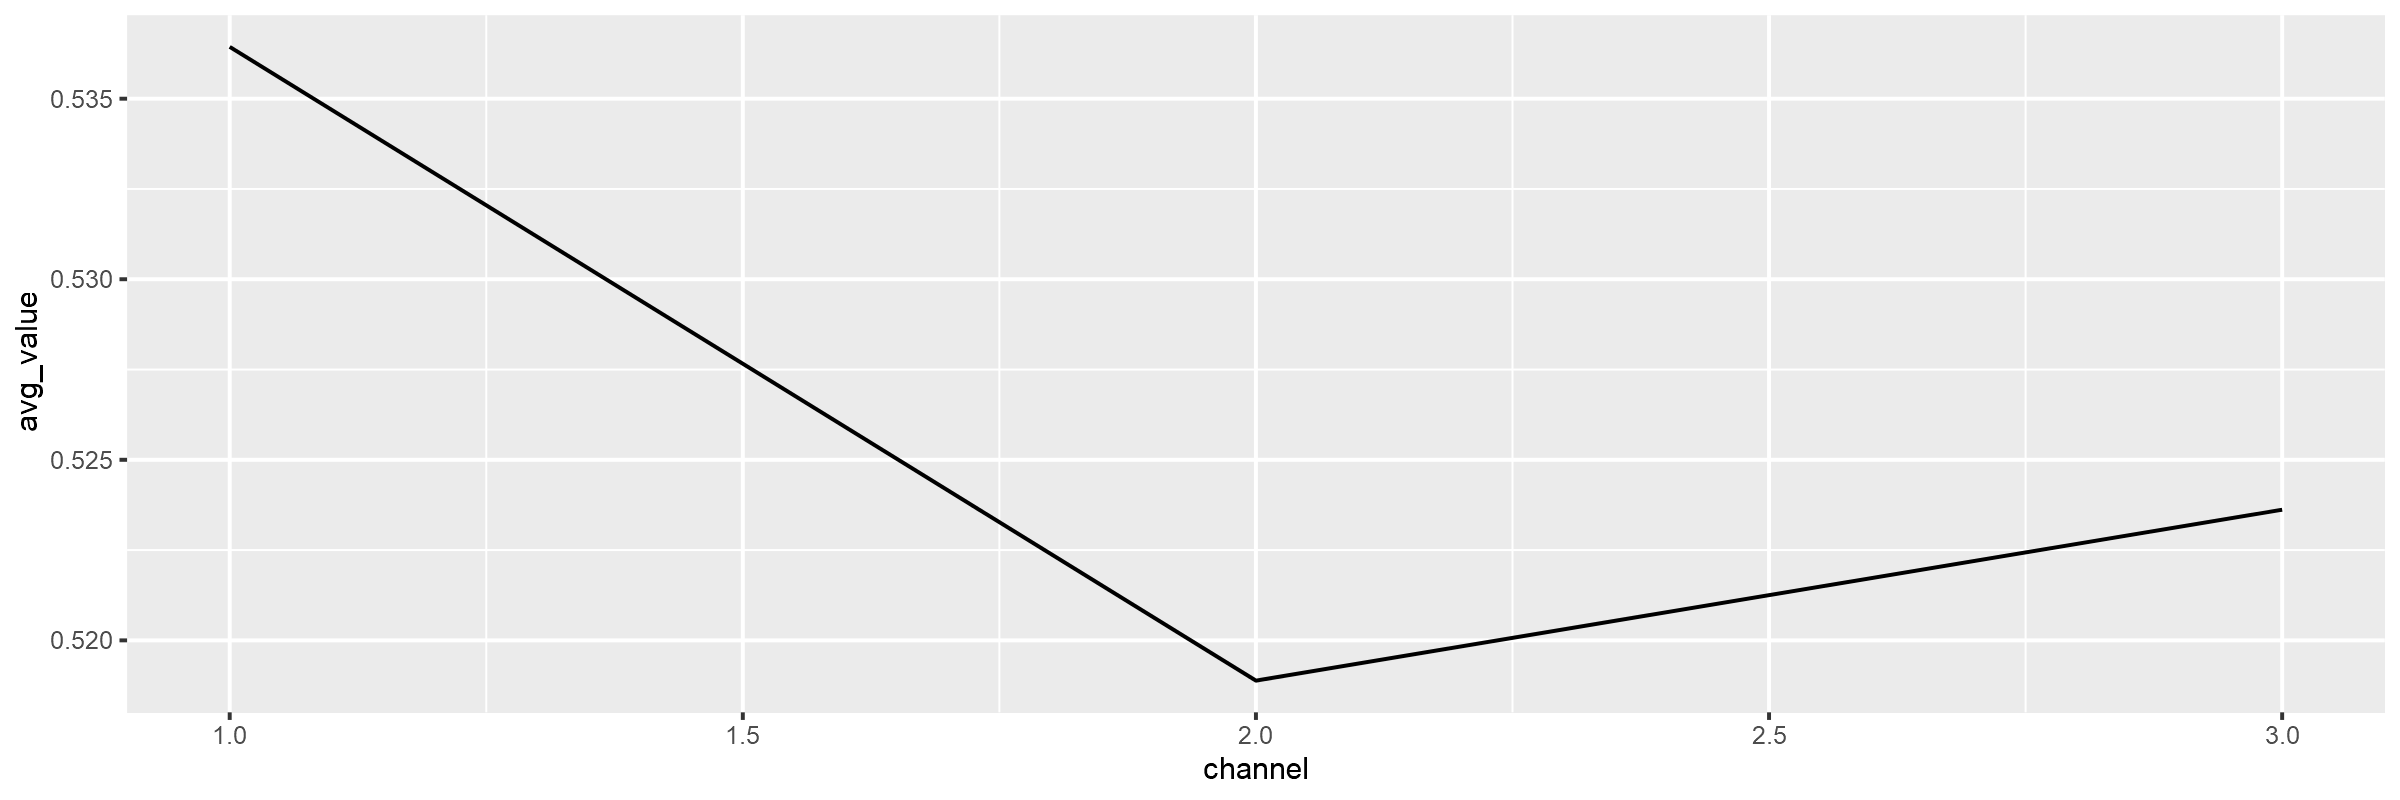

In [69]:
channel_avgs = image_dt[,.(avg_value = mean(value)),.(channel)]
channel_avgs
ggplot(data = channel_avgs, aes(x = channel, y = avg_value)) + geom_line()

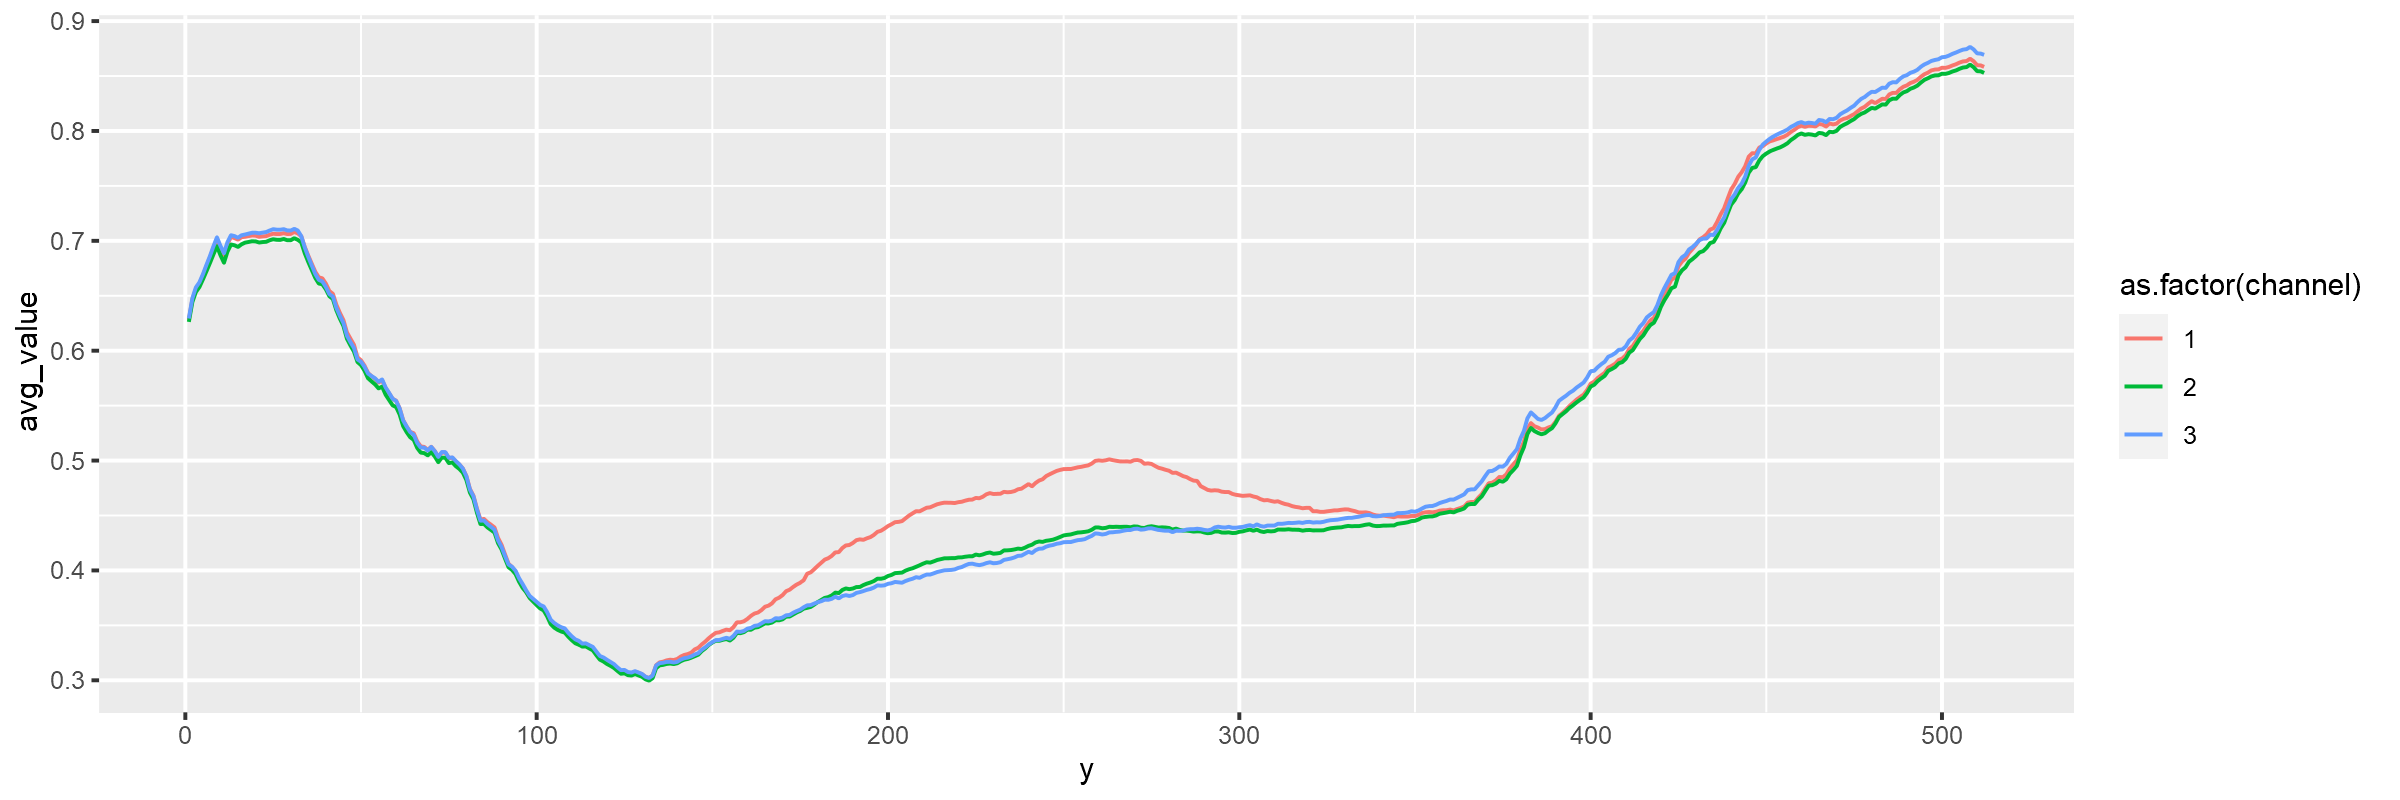

In [80]:
channel_avgs_cols = image_dt[,.(avg_value = mean(value)),.(y,channel)]
ggplot(data = channel_avgs_cols, aes(x = y, y = avg_value, color = as.factor(channel))) + geom_line()

The column averages of each channel seem to follow the same pattern. This means that the information carried by pixels is independent from the channels. In other words, channels of an image have very similar information about the image, on average.  

## Image Manipulations

In [81]:
substract_half = function(image_dt,channel_num){ # first half is substracted from the second half
    manip_image = copy(image_dt[channel == channel_num])
    manip_image = manip_image[order(y,x)]
    
    first_half  = manip_image[y <= 256]$value
    to_be_subtracted = c(rep(0,length(first_half)),first_half)
    
    manip_image$value = manip_image$value - to_be_subtracted
    manip_image[value < 0, value := 0] # corrections
    
    manip_image_data = manip_image[order(x,y)]$value
#    manip_image <- as.matrix(manip_image)
    return(manip_image_data)
}

In [82]:
c1 = substract_half(image_dt,1)
c2 = substract_half(image_dt,2)
c3 = substract_half(image_dt,3)
c_tot = c(c1,c2,c3)
head(c_tot,20)

[1] 0.2901961 0.3333333 0.3294118 0.3254902 0.2784314 0.2941176 0.3215686
 [8] 0.3137255 0.3176471 0.3137255 0.3568627 0.3803922 0.4156863 0.4274510
[15] 0.4431373 0.4235294 0.4039216 0.3843137 0.3215686 0.3764706

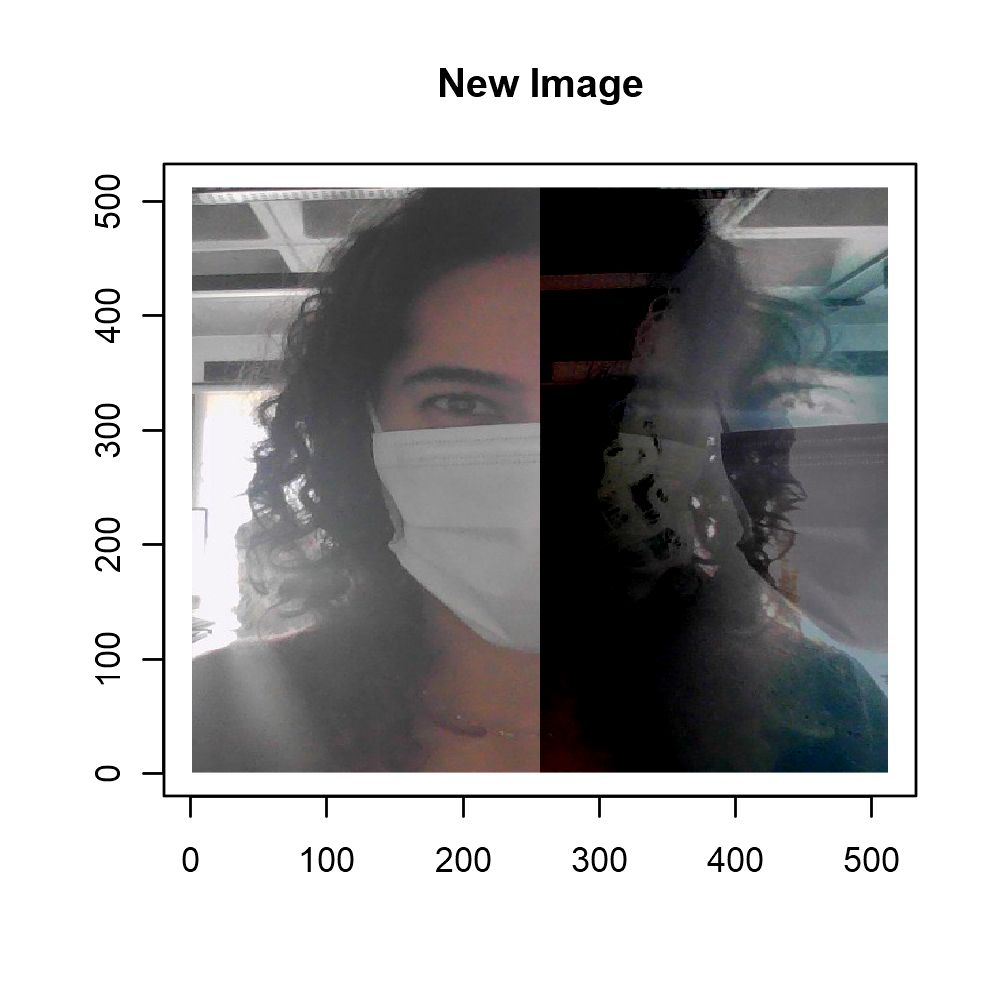

In [83]:
new_image = as.cimg(array(c_tot,c(512,512,3))) #Assumes it's a colour image (last dimension 3)

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "New Image")
rasterImage(new_image, 1, 1, 512, 512, angle = 0, interpolate = FALSE)

As the value of a pixel decreases, it seems that the brightness decreases as well (above). This also holds ofor each channel (below).

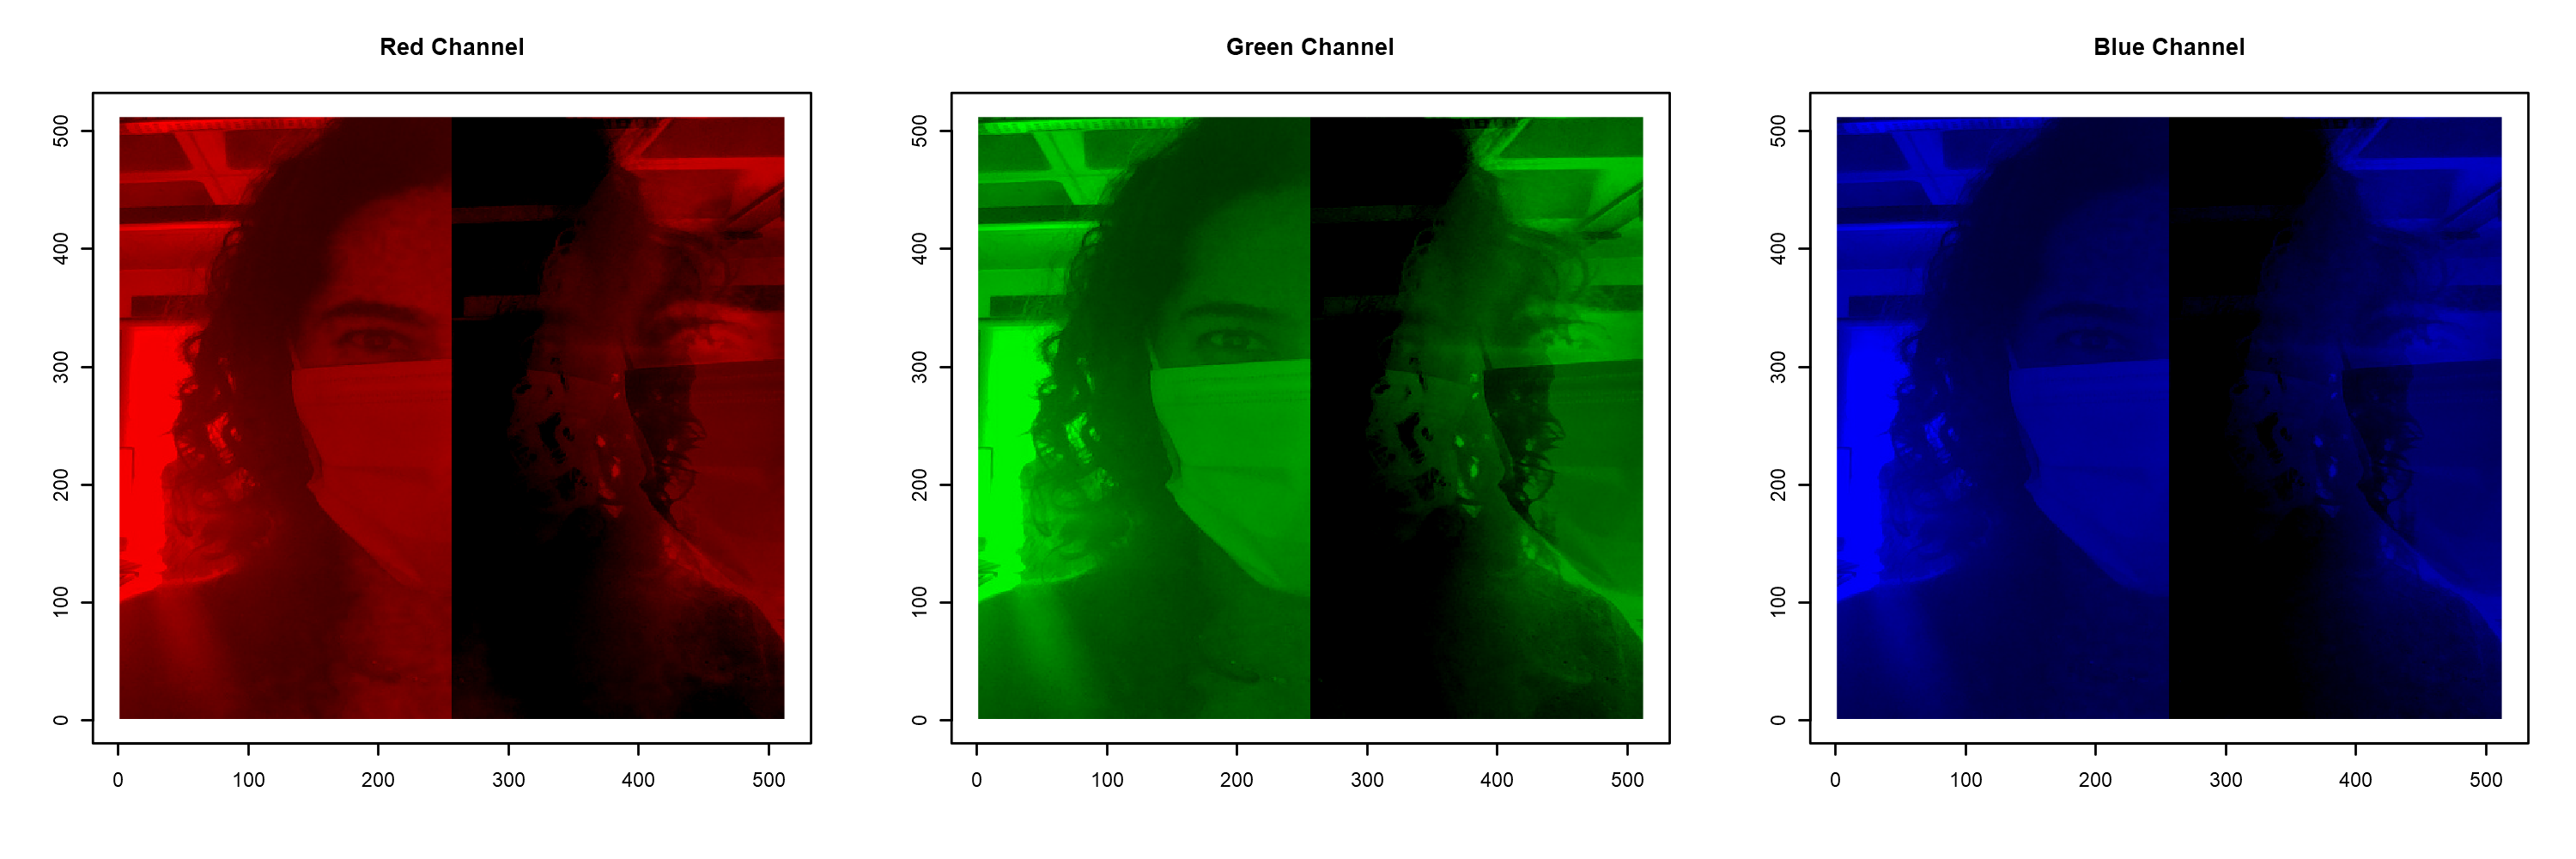

In [84]:
new_image_red <- copy(new_image)
G(new_image_red) <- 0
B(new_image_red) <- 0

new_image_green <- copy(new_image)
R(new_image_green) <- 0
B(new_image_green) <- 0

new_image_blue <- copy(new_image)
R(new_image_blue) <- 0
G(new_image_blue) <- 0

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)
# display each channel
par(mfrow = c(1, 3))
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "Red Channel")
rasterImage(new_image_red, 1, 1, 512, 512, angle = 0, interpolate = FALSE)
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "Green Channel")
rasterImage(new_image_green, 1, 1, 512, 512, angle = 0, interpolate = FALSE)
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "Blue Channel")
rasterImage(new_image_blue, 1, 1, 512, 512, angle = 0, interpolate = FALSE)

## Noisy Image

In [85]:
generate_noise = function(image_dt, channel_num){
    set.seed(channel_num)
    focus_channel = copy(image_dt[channel == channel_num])
    noise = runif(512*512,min = 0,max = (max(focus_channel$value)*0.1) )
    focus_channel$value = focus_channel$value+ noise
    return(focus_channel$value)
}

In [86]:
c1_noise = generate_noise(image_dt,1)
c2_noise = generate_noise(image_dt,2)
c3_noise = generate_noise(image_dt,3)
c_tot_noise = c(c1_noise,c2_noise,c3_noise)
head(c_tot_noise,20)

[1] 0.3167469 0.3705457 0.3866971 0.4163110 0.2985996 0.3839566 0.4160362
 [8] 0.3798053 0.3805585 0.3199041 0.3774602 0.3980478 0.4843886 0.4658614
[15] 0.5201214 0.4732993 0.4756834 0.4835043 0.3595721 0.4542151

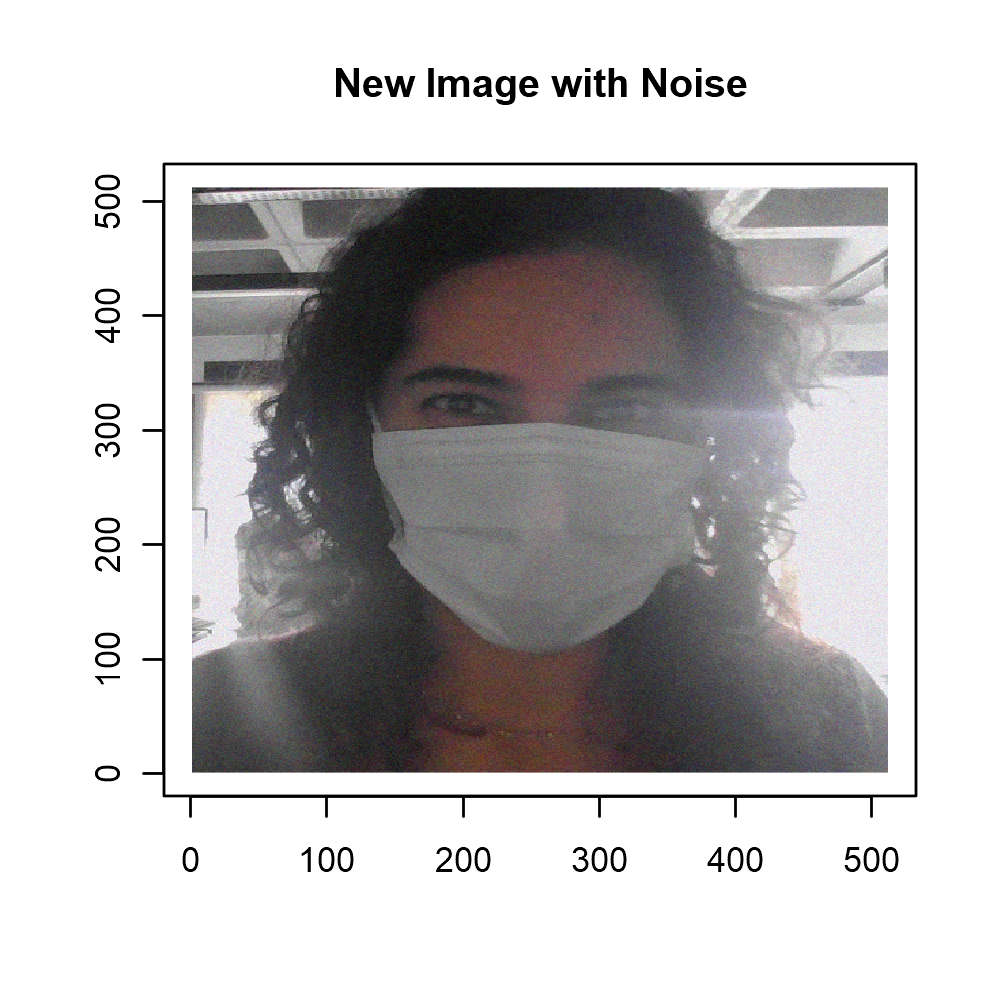

In [87]:
new_image_noise = as.cimg(array(c_tot_noise,c(512,512,3))) #Assumes it's a colour image (last dimension 3)

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "New Image with Noise")
rasterImage(new_image_noise, 1, 1, 512, 512, angle = 0, interpolate = FALSE)

Noise makes pixels more noticable in the image.

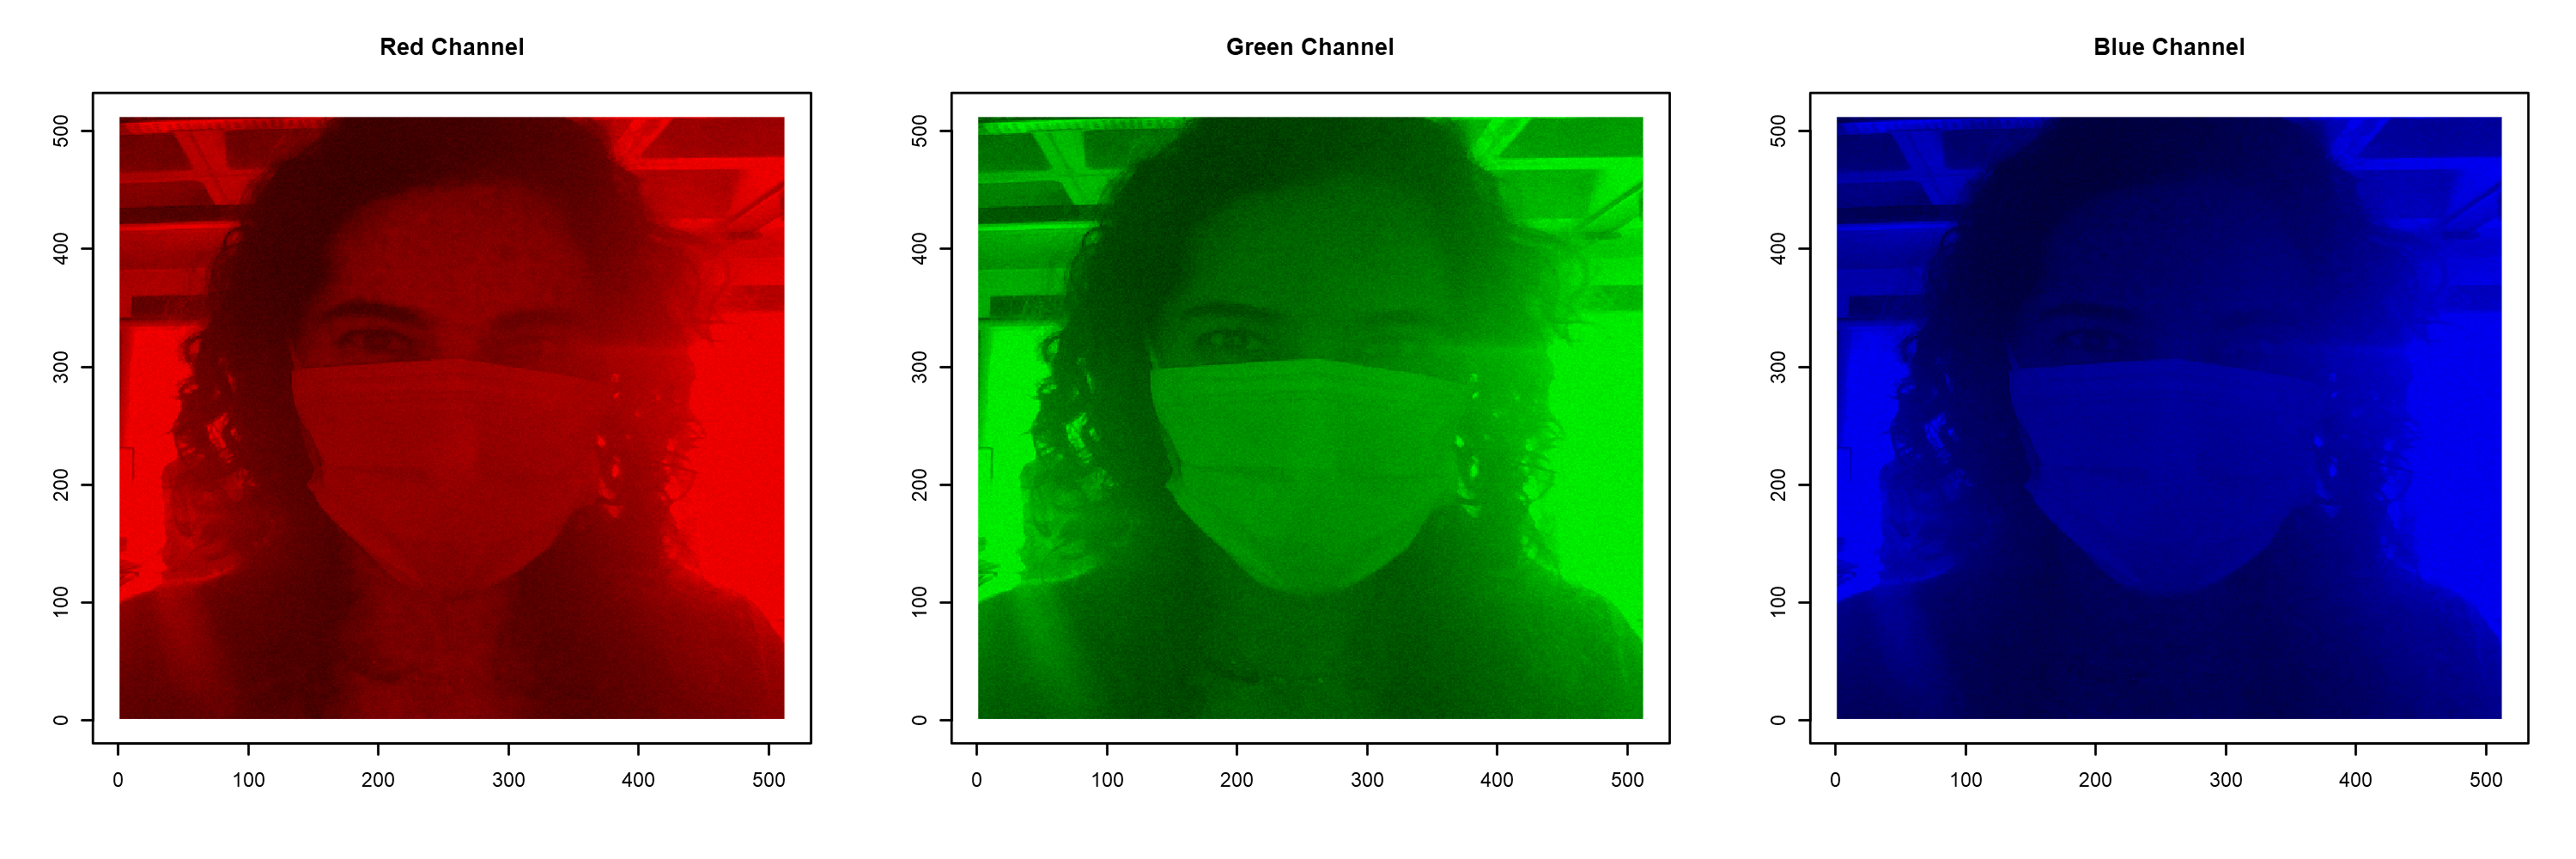

In [88]:
new_image_noise_red <- copy(new_image_noise)
G(new_image_noise_red) <- 0
B(new_image_noise_red) <- 0

new_image_noise_green <- copy(new_image_noise)
R(new_image_noise_green) <- 0
B(new_image_noise_green) <- 0

new_image_noise_blue <- copy(new_image_noise)
R(new_image_noise_blue) <- 0
G(new_image_noise_blue) <- 0

options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)
# display each channel
par(mfrow = c(1, 3))
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "Red Channel")
rasterImage(new_image_noise_red, 1, 1, 512, 512, angle = 0, interpolate = FALSE)
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "Green Channel")
rasterImage(new_image_noise_green, 1, 1, 512, 512, angle = 0, interpolate = FALSE)
plot(c(1, 512), c(1, 512), type = "n", xlab = "", ylab = "", main = "Blue Channel")
rasterImage(new_image_noise_blue, 1, 1, 512, 512, angle = 0, interpolate = FALSE)